#  Proteomics / Phosphorylation analysis in drosophila embrio
## SILAC dataset
We have three replicates (B1, B2, B3) and two conditions labelled with Heavy(H) and Light(L) SILAC isotopes. The experiment aims to identify changes at proteomic and p-proteomic levels.


### Import some library 

In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
sns.set(style="ticks")

def make_plot(df=pd.DataFrame(), x='', y='', hue=''):
    fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, hue=hue, data=df, palette="PRGn", ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(hue)
    plt.show()

def make_scatter_matrix(in_df):
    #sns.set(font_scale = 1.5)
    #sns.set(style="white")
    def corrfunc(x, y, **kws):
        r, _ = stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.2f}".format(r),
                    xy=(.1, .9), xycoords=ax.transAxes)
    
    selection =  in_df
    #selection = selection+1
    #selection = selection[selection.sum(axis=1)>5]
    print (selection.head())
    #selection = selection
    g = sns.PairGrid(selection, palette=["red"], size=2 )
    g.map_upper(plt.scatter, s=4)
    g.map_diag(sns.distplot, kde=False) 
    g.map_lower(sns.kdeplot, cmap="Blues_d") 
    g.map_lower(corrfunc)
    
    g.savefig('q1.svg')
    g.savefig('q1.png')
    g.savefig('q1.pdf')
   
    plt.show()
 

### Let's start with some sanity check of the dataset
### We expect the typycal median score of the peptides identified with Andromeda to be > 50

In [2]:

#use the evidence file for sanity check
df = pd.read_table('evidence.txt')
#make log10 of intensity for better visualization
df['log10intensity']=np.log10(df['Intensity'])

/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


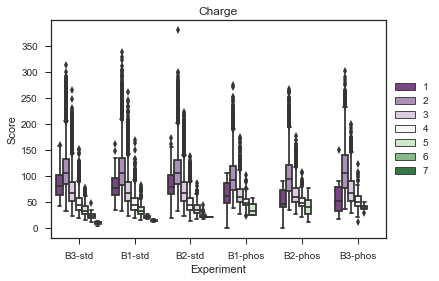

In [3]:
#this plot visualize the peptide score vs charge
make_plot(df=df, x="Experiment", y="Score", hue="Charge")

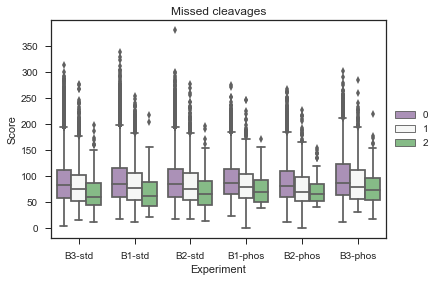

In [4]:
#this plot visualize the peptide score vs the number of miss cleavages in the peptide
make_plot(df=df, x="Experiment", y="Score", hue="Missed cleavages")

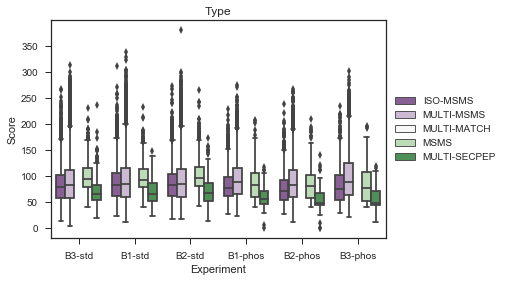

In [6]:
make_plot(df=df, x="Experiment", y="Score", hue="Type")
#note
#The type of MS/MS spectrum this sequence is derived from.
#ISO-MSMS – MS/MS from an identified isotope cluster.
#MULTI-MSMS – MS/MS from an identified labeling cluster.
#MSMS – MS/MS for an unidentified peak.

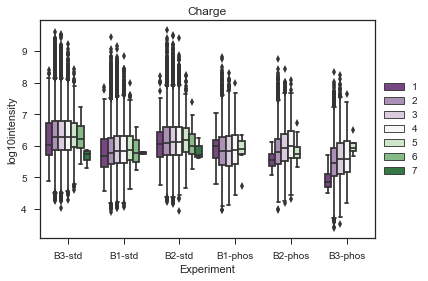

In [7]:
make_plot(df=df, x="Experiment", y="log10intensity", hue="Charge")
#here actually we have an alarm bell, generally we observere a median intensity > 7
#This would indicate too less starting material or loss of sample during preparation

### A look to the fraction of missed cleavages

Text(0.5,1,'fraction of Missed cleavages')

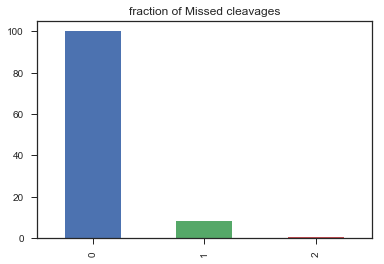

In [23]:
temp = df["Missed cleavages"].value_counts()/df["Missed cleavages"].value_counts()[0]*100
temp.plot(kind='bar')
plt.title('fraction of Missed cleavages')
#generally we see less less that 10% for 1 or 2 Missed cleavages

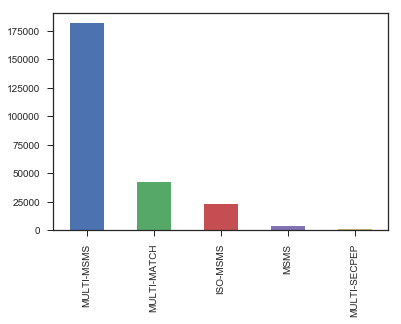

In [26]:
#This is actually the second allarm bell
#for a silac experiments we expect the ISO-MSMS count 
#to be higer respect to the other form of
#ms type
temp = df["Type"].value_counts()
temp.plot(kind='bar')

## Let's now visualize the reproducibility of the dataset at protein level

In [27]:
#load data and remove rubbish
df = pd.read_table('proteinGroups.txt')
df = df[df['Only identified by site']!='+']
df = df[df['Reverse']!='+']
df = df[df['Potential contaminant']!='+']


/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (154,155) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


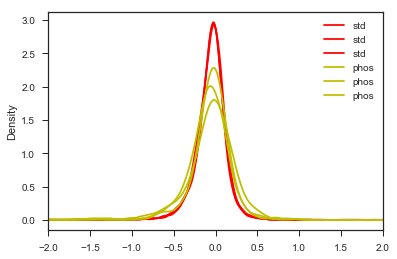

In [30]:
temp = df['Ratio H/L normalized B1-std'].replace([np.inf, -np.inf], np.nan)
ax = np.log2(temp.dropna()).plot(kind='kde', label='std',c='r')
temp = df['Ratio H/L normalized B2-std'].replace([np.inf, -np.inf], np.nan)
ax = np.log2(temp.dropna()).plot(kind='kde',ax=ax,label='std',c='r')
temp = df['Ratio H/L normalized B3-std'].replace([np.inf, -np.inf], np.nan)
ax = np.log2(temp.dropna()).plot(kind='kde',ax=ax,label='std',c='r')

temp = df['Ratio H/L normalized B1-phos'].replace([np.inf, -np.inf], np.nan)
ax = np.log2(temp.dropna()).plot(kind='kde',ax=ax,label='phos',c='y')
temp = df['Ratio H/L normalized B2-phos'].replace([np.inf, -np.inf], np.nan)
ax = np.log2(temp.dropna()).plot(kind='kde',ax=ax,label='phos',c='y')
temp = df['Ratio H/L normalized B3-phos'].replace([np.inf, -np.inf], np.nan)
ax = np.log2(temp.dropna()).plot(kind='kde',ax=ax,label='phos',c='y')
ax.set_xlim(-2,2)
plt.legend()
plt.show()
#log ratio form a gaussian araund zero, good

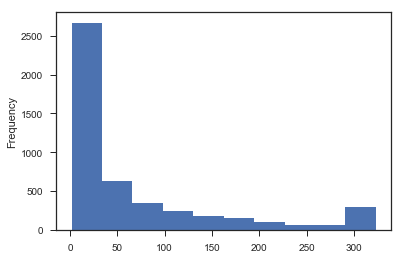

In [31]:
#generally we observe higher amount of protein with a score > 300 (highest in maxquant)
temp = df['Score'].replace([np.inf, -np.inf], np.nan)
temp = temp.dropna()
ax = temp.plot(kind='hist', label='score')
plt.show()

           B1        B2        B3
150  0.007052  0.286053  0.083247
151  0.088006  0.008774  0.100305
152 -0.084410 -0.121000  0.028852
153 -0.030236 -0.058788 -0.140205
154 -0.358491 -0.353764 -0.419198


/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


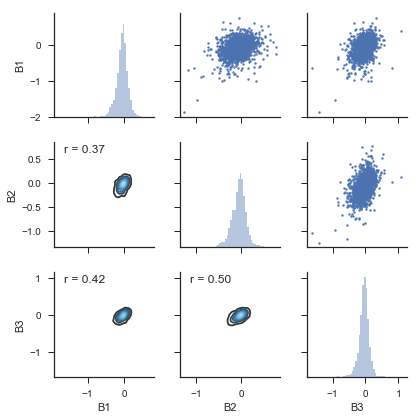

In [37]:
temp = df[['Ratio H/L normalized B1-std', 'Ratio H/L normalized B2-std', 'Ratio H/L normalized B3-std']]  
temp.columns = ['B1','B2','B3']
temp = np.log2(temp)
make_scatter_matrix(temp.dropna()) 

### B2 vs B3 correlate better, they are the samples with an higher intensity values on average (see above charge plot)

### Does the correlation improve by increasing score and intensity thresholds?

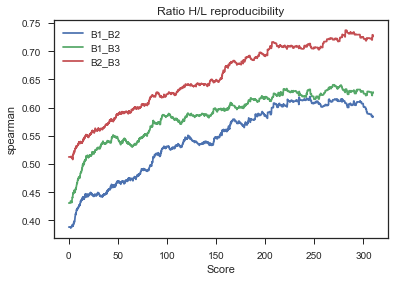

/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


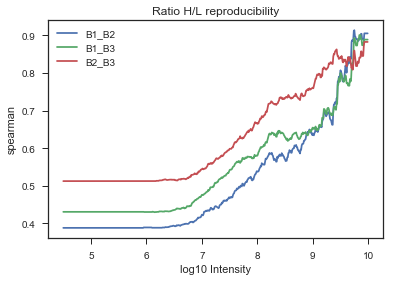

In [39]:
def correlete(df=pd.DataFrame(), method='spearman'):
    temp = df[['Ratio H/L B1-std', 'Ratio H/L B2-std', 'Ratio H/L B3-std', 'Score']]
    list_a = []
    list_b = []
    list_c = []
    start = 0
    end = 310
    every = 0.1
    for item in np.arange(start, end, every):
        selection = temp[temp['Score']>item]
        del selection['Score']
        selection = np.log2(selection)    
        p = selection.corr(method=method)
        #print p
        #print p.iloc[0,1],'p.iloc[0,1]'
        #print p.iloc[0,2],'p.iloc[0,2]'
        #print p.iloc[1,2],'p.iloc[1,2]'
                
        a, b, c = p.iloc[0,1],p.iloc[0,2],p.iloc[1,2]
        list_a.append(a)
        list_b.append(b) 
        list_c.append(c)  
    res = pd.DataFrame()
    res['B1_B2']=list_a
    res['B1_B3']=list_b
    res['B2_B3']=list_c
    res['x']=np.arange(start, end, every)
    ax = res.plot(x='x',y='B1_B2')
    ax = res.plot(x='x',y='B1_B3',ax=ax)
    ax = res.plot(x='x',y='B2_B3',ax=ax)
    ax.set_xlabel('Score')
    ax.set_ylabel(method)    
    plt.title('Ratio H/L reproducibility')
    plt.show()
    
    
    temp = df[['Ratio H/L B1-std', 'Ratio H/L B2-std', 'Ratio H/L B3-std', 'Intensity']]
    temp['Intensity']=np.log10(temp['Intensity'])
    list_a = []
    list_b = []
    list_c = []
    start = 4.5
    end = 10
    every = 0.01
    for item in np.arange(start, end, every):
        selection = temp[temp['Intensity']>item]
        #print  item, selection.shape
        del selection['Intensity']
        selection = np.log10(selection)    
        p = selection.corr(method=method)
        a, b, c = p.iloc[0,1],p.iloc[0,2],p.iloc[1,2]
        list_a.append(a)
        list_b.append(b) 
        list_c.append(c)  
    res = pd.DataFrame()
    res['B1_B2']=list_a
    res['B1_B3']=list_b
    res['B2_B3']=list_c
    res['x']=np.arange(start, end, every)
    ax = res.plot(x='x',y='B1_B2')
    ax = res.plot(x='x',y='B1_B3',ax=ax)
    ax = res.plot(x='x',y='B2_B3',ax=ax)
    ax.set_xlabel('log10 Intensity')
    ax.set_ylabel(method) 
    plt.title('Ratio H/L reproducibility')
    plt.show()
    
#for m in ['pearson', 'kendall', 'spearman']:
correlete(df, method='spearman')

### The correletion improve, expecially for B3/B3 couple

/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


           B1        B2        B3
157  0.105946  0.060877  0.006908
159  0.235359  0.196229  0.296428
164 -0.034160 -0.072377 -0.041996
172 -0.149009 -0.214073 -0.180430
177  0.086512  0.028852  0.094641


/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


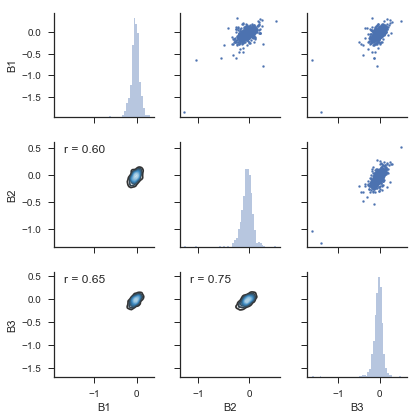

In [41]:
temp = df[df['Score']>160]
temp = temp[np.log10(df['Intensity'])>7]
temp = temp[['Ratio H/L normalized B1-std', 'Ratio H/L normalized B2-std', 'Ratio H/L normalized B3-std']]  
temp.columns = ['B1','B2','B3']
temp = np.log2(temp)
make_scatter_matrix(temp)  



## Let's have a look at the most changing proteins   

In [48]:
import warnings
warnings.filterwarnings('ignore')
temp = df[df['Score']>160]
temp = temp[np.log10(df['Intensity'])>7]
temp2 = temp[['Ratio H/L normalized B1-std', 'Ratio H/L normalized B2-std', 'Ratio H/L normalized B3-std']]  
temp2['Protein IDs']=[n.split(' ')[0] for n in temp['Protein IDs']]
temp2['desc']=[' '.join(n.split(' ')[1:]) for n in temp['Protein IDs']]
temp2['avg_B2_B3']=temp2[['Ratio H/L normalized B2-std', 'Ratio H/L normalized B3-std']].mean(axis=1)
temp2.sort_values(by='avg_B2_B3',inplace=True)
temp2.to_csv('test.txt',sep='\t')

In [51]:
temp2[['Protein IDs','desc','avg_B2_B3']].head()

,Protein IDs,desc,avg_B2_B3
2428,tr|B7Z001|B7Z001_DROME,"Fatty acid synthase 1, isoform C OS=Drosophila...",0.397335
2616,tr|Q8INW9|Q8INW9_DROME,"Fondue, isoform A OS=Drosophila melanogaster O...",0.405305
4617,tr|Q9VVU1|Q9VVU1_DROME,CG3902 OS=Drosophila melanogaster OX=7227 GN=G...,0.738895
2017,tr|A0A126GUM8|A0A126GUM8_DROME,"Lingerer, isoform L OS=Drosophila melanogaster...",0.762645
2062,tr|Q9VNC4|Q9VNC4_DROME,"Uncharacterized protein, isoform B OS=Drosophi...",0.780035


In [52]:
temp2[['Protein IDs','desc','avg_B2_B3']].tail()

,Protein IDs,desc,avg_B2_B3
230,tr|E1JGV6|E1JGV6_DROME,"Nucleolar protein at 60B, isoform C OS=Drosoph...",1.15010
4345,tr|Q9VQI5|Q9VQI5_DROME,LP04564p OS=Drosophila melanogaster OX=7227 GN...,1.18295
3018,tr|Q7K4H1|Q7K4H1_DROME,LD40680p OS=Drosophila melanogaster OX=7227 GN...,1.18640
159,tr|A0A0B4LEY4|A0A0B4LEY4_DROME,PAN2-PAN3 deadenylation complex catalytic subu...,1.18690
3214,tr|Q9VLY9|Q9VLY9_DROME,"Thioester-containing protein 2, isoform B OS=D...",1.43755


# Let's move on visualising the phospho-proteomic results

In [2]:
#load phosphoprotein 
df = pd.read_table('Phospho (STY)Sites.txt')
df['filter']=[1 if '__' in n else 0 for n in df['Protein']]
df = df[df['filter']==0]
df  = df[df['Localization prob']>0.75]
df.head()

/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Proteins,Positions within proteins,Leading proteins,Protein,Fasta headers,Localization prob,Score diff,PEP,Score,Delta score,...,Best localization scan number,Best score evidence ID,Best score MS/MS ID,Best score raw file,Best score scan number,Best PEP evidence ID,Best PEP MS/MS ID,Best PEP raw file,Best PEP scan number,filter
51,sp|A1A708|Y4951_DROME Uncharacterized protein ...,212,sp|A1A708|Y4951_DROME Uncharacterized protein ...,sp|A1A708|Y4951_DROME Uncharacterized protein ...,>sp|A1A708|Y4951_DROME Uncharacterized protein...,0.857649,7.92057,1.372710e-04,89.344,56.598,...,2204,18281,26983,239-B2-T3,1629,18281,26983,239-B2-T3,1629,0
56,sp|A1A708|Y4951_DROME Uncharacterized protein ...,200,sp|A1A708|Y4951_DROME Uncharacterized protein ...,sp|A1A708|Y4951_DROME Uncharacterized protein ...,>sp|A1A708|Y4951_DROME Uncharacterized protein...,0.940677,13.13640,8.499820e-03,75.877,14.533,...,826,191990,276257,239-B3-T-1,818,191990,276257,239-B3-T-1,818,0
57,sp|A1A708|Y4951_DROME Uncharacterized protein ...,202,sp|A1A708|Y4951_DROME Uncharacterized protein ...,sp|A1A708|Y4951_DROME Uncharacterized protein ...,>sp|A1A708|Y4951_DROME Uncharacterized protein...,0.995308,23.38920,4.952110e-03,85.493,20.782,...,905,191992,276259,239-B3-T-2,905,191992,276259,239-B3-T-2,905,0
58,sp|A1A708|Y4951_DROME Uncharacterized protein ...,442,sp|A1A708|Y4951_DROME Uncharacterized protein ...,sp|A1A708|Y4951_DROME Uncharacterized protein ...,>sp|A1A708|Y4951_DROME Uncharacterized protein...,1.000000,81.80930,1.248860e-07,118.050,70.414,...,13584,248135,357982,239-B1-T8,10080,248135,357982,239-B1-T8,10080,0
59,sp|A1A708|Y4951_DROME Uncharacterized protein ...,443,sp|A1A708|Y4951_DROME Uncharacterized protein ...,sp|A1A708|Y4951_DROME Uncharacterized protein ...,>sp|A1A708|Y4951_DROME Uncharacterized protein...,1.000000,81.70200,4.174620e-03,83.317,56.192,...,13584,248139,357990,239-B2-T8,13584,248136,357984,239-B1-T8,10255,0


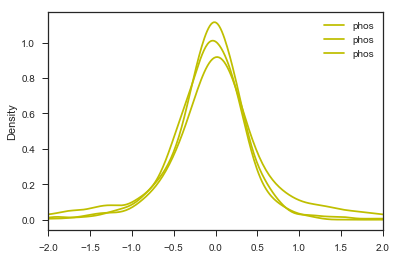

In [3]:
fig,ax = plt.subplots()
temp = df['Ratio H/L normalized B1-phos___1'].replace([np.inf, -np.inf], np.nan)
ax = np.log2(temp.dropna()).plot(kind='kde',ax=ax,label='phos',c='y')
temp = df['Ratio H/L normalized B2-phos___1'].replace([np.inf, -np.inf], np.nan)
ax = np.log2(temp.dropna()).plot(kind='kde',ax=ax,label='phos',c='y')
temp = df['Ratio H/L normalized B3-phos___1'].replace([np.inf, -np.inf], np.nan)
ax = np.log2(temp.dropna()).plot(kind='kde',ax=ax,label='phos',c='y')
ax.set_xlim(-2,2)
plt.legend()
plt.show()
#check the log data is centred around zero

          B1        B2        B3
64  0.313594  0.050885 -0.328471
66  0.533264 -0.019741 -0.174719
67  0.359071  0.476537 -0.306680
68  0.028993  0.091124  0.115433
69 -0.262971 -0.834776  1.796847


/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


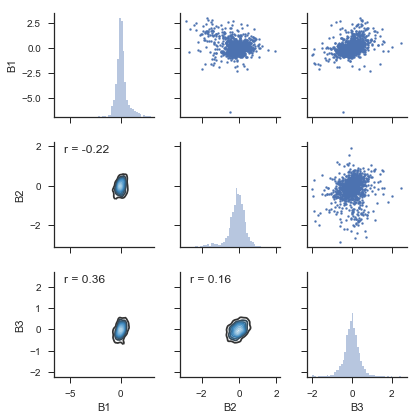

In [31]:
temp  = df[['Ratio H/L normalized B1-phos___1',
            'Ratio H/L normalized B2-phos___1',
            'Ratio H/L normalized B3-phos___1']]
temp.columns = ['B1', 'B2', 'B3']
make_scatter_matrix(np.log2(temp[['B1', 'B2', 'B3']]).dropna()) 

### the phosphosite have less reproducibility than protein dataset
#### let's see if by increasing score or intensity the reproducibility improve 

          B1        B2        B3     Score
64  0.313594  0.050885 -0.328471  2.149219
66  0.533264 -0.019741 -0.174719  2.047820
67  0.359071  0.476537 -0.306680  1.819570
68  0.028993  0.091124  0.115433  2.307924
69 -0.262971 -0.834776  1.796847  1.720143
2.47845105315 Score


/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log2
/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log2


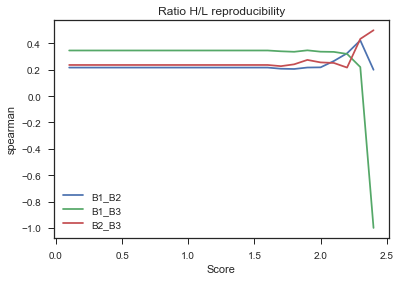

In [32]:
def correlate(df=pd.DataFrame(), 
              method='pearson', 
              tag='-phos',
              ref_col = 'Score'):
  
    print (df.head() )       
    score_max = df[ref_col].max()
    list_a = []
    list_b = []
    list_c = []
    start = 0.1
    end = score_max
    every = 0.1
    print (score_max, ref_col)
    for item in np.arange(start, end, every):
        #print item
        selection = df[df[ref_col]>item]
        #print selection.head()
        del selection[ref_col]
        selection = np.log2(selection)  
        #print selection.head()
        p = selection.corr(method=method)
        a, b, c = p.iloc[0,1],p.iloc[0,2],p.iloc[1,2]
        list_a.append(a)
        list_b.append(b) 
        list_c.append(c)  
        
        
    res = pd.DataFrame()
    res['B1_B2']=list_a
    res['B1_B3']=list_b
    res['B2_B3']=list_c
    res['x']=np.arange(start, end, every)
    ax = res.plot(x='x',y='B1_B2')
    ax = res.plot(x='x',y='B1_B3',ax=ax)
    ax = res.plot(x='x',y='B2_B3',ax=ax)
    ax.set_xlabel('Score')
    ax.set_ylabel(method)    
    plt.title('Ratio H/L reproducibility')
    plt.show()

temp = np.log2(temp)
temp['Score']=np.log10(df['Score'])
correlate(df=temp.dropna(), ref_col = 'Score', method='spearman')

/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log2
/Users/mtinti/miniconda3/envs/visualize_ttp/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log2


          B1        B2        B3     Score
64  0.313594  0.050885 -0.328471  6.318543
66  0.533264 -0.019741 -0.174719  7.267829
67  0.359071  0.476537 -0.306680  7.730047
68  0.028993  0.091124  0.115433  7.522327
69 -0.262971 -0.834776  1.796847  6.392380
9.34590279648 Score


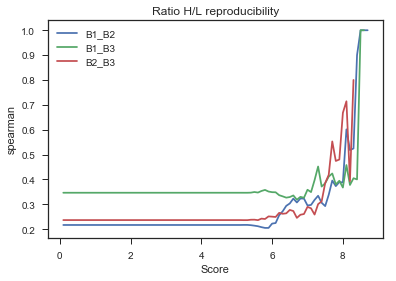

In [33]:
temp['Score']=np.log10(df['Intensity'])
correlate(df=temp.dropna(), ref_col = 'Score', method='spearman')

### we can see a general improving trend, expecially for intensity.